In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

In [6]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
! kaggle datasets download -d ulkutuncerkucuktas/turkey-earthquake-relief-tweets-dataset

  0% 0.00/44.2k [00:00<?, ?B/s]
100% 44.2k/44.2k [00:00<00:00, 41.1MB/s]


### Extraction data and inspecting data


In [8]:
zip_ref = zipfile.ZipFile("/content/turkey-earthquake-relief-tweets-dataset.zip")
zip_ref.extractall()
zip_ref.close()

In [9]:
df = pd.read_csv("dataset.csv")

In [10]:
df.head()

,Unnamed: 0,Tweets,Class
0,0,Kahramanmaraş türkoğlu ilçesi şekeroba köyü ça...,1.0
1,1,"Teyitli, ses var, köpekler tepki veriyor. Her...",1.0
2,2,0539 693 27 99 bu arkadaş Kahramanmaraş’ta çad...,1.0
3,3,Babamın yaşadığı yere henüz yardım ulaşmamış ş...,1.0
4,4,Samsun Atakum'da 18 adet yeni eşyalı daire var...,1.0


In [11]:
df.describe()


,Unnamed: 0,Class
count,499.000000,499.000000
mean,249.000000,0.599198
std,144.193157,0.490553
min,0.000000,0.000000
25%,124.500000,0.000000
50%,249.000000,1.000000
75%,373.500000,1.000000
max,498.000000,1.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  499 non-null    int64  
 1   Tweets      499 non-null    object 
 2   Class       499 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 11.8+ KB


In [13]:
df.isnull().sum()

Unnamed: 0    0
Tweets        0
Class         0
dtype: int64

In [14]:
df.columns

Index(['Unnamed: 0', 'Tweets', 'Class'], dtype='object')

In [15]:
df["Tweets"][0]

'Kahramanmaraş türkoğlu ilçesi şekeroba köyü çağrı sokak no 4 çadır yatak ısıtıcı ölen insanlae için de kefen ihtiyacı var  iletişim:05435379496'

In [16]:
import random
def show_random_tweet_class(df):
  rand_value = random.randint(0,len(df))
  target = df["Tweets"][rand_value]
  label = df["Class"][rand_value]
  print(f"Tweet info \n {target} \n Tweet class : {label}")

In [17]:
show_random_tweet_class(df)

Tweet info 
 Malatya hekimhan ilçesi girmana mahallesi akpinar küme evler, Yahyali küme evleri gokceler küme evleri / hiç yardım ulaşmadı. Yiyecek kuru gıda yakacak kömür  ve giyecek & battaniye tel: +90 530 200 04 89 Yücel bey 
 Tweet class : 1.0


## Split data into train and test sets


In [18]:
from sklearn.model_selection import train_test_split


X = df[["Tweets"]]
y = df["Class"]
train_sentences, val_sentences, train_labels, val_labels = train_test_split(X.to_numpy(),
                                                                            y.to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [19]:
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(449, 50, 449, 50)

### Converting text into numbers using TextVextorization


In [20]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [21]:
tokens = 10000
average_length_tweet = 20

text_vectorizer = TextVectorization(max_tokens=tokens,
                                    output_mode="int",
                                    output_sequence_length=average_length_tweet)
text_vectorizer.adapt(train_sentences)

#### Check for unique words in tweets and least frequent


In [22]:
words_in_vocab = text_vectorizer.get_vocabulary()
words_in_vocab[:10]

['',
 '[UNK]',
 've',
 'var',
 'deprem',
 'gıda',
 'bir',
 'battaniye',
 'acil',
 'mahallesi']

In [23]:
words_in_vocab[-30:-20]

['05349164014',
 '05342029675',
 '0534',
 '05334776882',
 '05333117457',
 '05330555658',
 '05327275717',
 '05326906575',
 '05326801242',
 '05322271102']

### Creating embedding 

In [24]:
import tensorflow as tf
dims = 128
embedding = tf.keras.layers.Embedding(input_dim=tokens,
                                      output_dim=dims,
                                      input_length=average_length_tweet)


### Model 0: baseline


In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculating model accurancy, precision, recall and f1 score
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  ## Calculate model precision
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  
  model_results = {"accuracy": model_accuracy,
                   "precision":model_precision * 100,
                   "recall":model_recall * 100,
                   "f1":model_f1 * 100}

  return model_results

In [26]:
train_sentences = train_sentences[:,0]
val_sentences = val_sentences[:,0]


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
baseline_score = model_0.score(val_sentences, val_labels)
baseline_score

0.96

In [29]:
baseline_preds = model_0.predict(val_sentences)

In [30]:
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 96.0,
 'precision': 96.22857142857143,
 'recall': 96.0,
 'f1': 95.93382352941177}

### Model 1: Dense Model


In [31]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.GlobalAveragePooling1D(name="global_avg_pool_layer")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="mode_1_dense")

In [32]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels),
                              verbose=0)

In [33]:
model_1_preds = model_1.predict(val_sentences)

2/2 [==============================] - 0s 6ms/step


In [34]:
model_1_preds = tf.squeeze(tf.round(model_1_preds))

In [35]:
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results

{'accuracy': 98.0,
 'precision': 98.05882352941177,
 'recall': 98.0,
 'f1': 97.9846223428313}

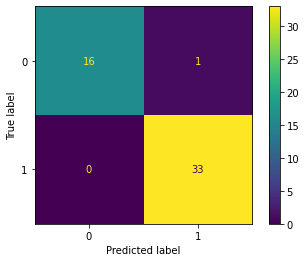

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(val_labels, model_1_preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

### Model 2: LSTM

In [36]:
inputs = tf.keras.layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# x = tf.keras.layers.GlobalAveragePooling1D(name="global_avg_pool_layer")(x)
x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
x = tf.keras.layers.LSTM(64)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [37]:
## Compile 
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
## Fit
history_model_2 = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
15/15 [==============================] - 10s 246ms/step - loss: 0.3200 - accuracy: 0.9666 - val_loss: 0.2774 - val_accuracy: 0.9200
Epoch 2/5
15/15 [==============================] - 1s 92ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.4105 - val_accuracy: 0.9400
Epoch 3/5
15/15 [==============================] - 2s 100ms/step - loss: 6.2512e-04 - accuracy: 1.0000 - val_loss: 0.4723 - val_accuracy: 0.9400
Epoch 4/5
15/15 [==============================] - 2s 102ms/step - loss: 2.9366e-04 - accuracy: 1.0000 - val_loss: 0.4985 - val_accuracy: 0.9400
Epoch 5/5
15/15 [==============================] - 1s 39ms/step - loss: 2.1138e-04 - accuracy: 1.0000 - val_loss: 0.5121 - val_accuracy: 0.9400


In [38]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

2/2 [==============================] - 1s 8ms/step


{'accuracy': 94.0, 'precision': 94.5, 'recall': 94.0, 'f1': 93.84011220196354}

## Model 3: TensorFlow Hub (USE feature extractor)

In [39]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [40]:
model_3 = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")
],name="model_3_USE")

## Compile 
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
## Fit
history_model_3 = model_3.fit(train_sentences,
                              train_labels,
                              epochs=100,
                              validation_data=(val_sentences, val_labels),
                              verbose=0)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [41]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

2/2 [==============================] - 0s 14ms/step


{'accuracy': 84.0, 'precision': 89.12, 'recall': 84.0, 'f1': 84.42036124794745}

## Conclusion:
### Models dont beat baseline, so we will change params in TextVectorization and in embedding and try to upgrade our model 2: LSTM so in beat baseline

In [42]:
def plot_history(history):
  '''
  Takes history of our model and plot accuracy and loss function

  parms:
  history - model history

  output:
  -
  '''
  loss = history.history["loss"]
  acc = history.history["accuracy"]
  number_of_elements = len(loss)
  epochs = np.linspace(1,number_of_elements,number_of_elements)

  ## Plotting functions
  fig,ax = plt.subplots(2,1, figsize=(10,7))
  ax[0].plot(epochs, acc)
  ax[0].set_title("Accuracy")  
  ax[1].plot(epochs, loss)
  ax[1].set_title("Loss function")
  plt.show()

In [43]:
tokens = 20
length_sentences = 70

text_vectorizer = TextVectorization(max_tokens=tokens,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=length_sentences,
                                    pad_to_max_tokens=True)
text_vectorizer.adapt(train_sentences)

In [44]:
dims = 32
embedding = tf.keras.layers.Embedding(input_dim=tokens,
                                      output_dim=dims,
                                      input_length=average_length_tweet)

In [45]:
random_sentence = random.choice(train_sentences)
print(f"Orginal text:\n {random_sentence}\
      \n Embedded version:")

sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Orginal text:
 İNSAN BOZULMUŞ. HÜKÛMET  Ev kredi faizlerini düşürür ev fiyatları artar. Otomobil vergisini düşürür araba fiyatları artar. Gıda ürünlerinden aldığı vergiyi yüzde 1'e düşürür gıda fiyatları artar. Deprem sel yangın olur ev kiraları artar İNSANLAR ŞEREFSİZ OLMUŞ   DEVLET NE YAPSIN      
 Embedded version:


<tf.Tensor: shape=(1, 70, 32), dtype=float32, numpy=
array([[[ 0.03744874,  0.03977436, -0.01934597, ..., -0.04241788,
          0.04333859, -0.03611724],
        [ 0.03744874,  0.03977436, -0.01934597, ..., -0.04241788,
          0.04333859, -0.03611724],
        [ 0.03744874,  0.03977436, -0.01934597, ..., -0.04241788,
          0.04333859, -0.03611724],
        ...,
        [-0.03319892, -0.03501267, -0.03951026, ..., -0.0371205 ,
          0.01802352,  0.01615502],
        [-0.03319892, -0.03501267, -0.03951026, ..., -0.0371205 ,
          0.01802352,  0.01615502],
        [-0.03319892, -0.03501267, -0.03951026, ..., -0.0371205 ,
          0.01802352,  0.01615502]]], dtype=float32)>

In [46]:
inputs = tf.keras.layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
x = tf.keras.layers.LSTM(32)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")
## Compile 
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                metrics=["accuracy"])
## Fit
history_model_4 = model_4.fit(train_sentences,
                              train_labels,
                              epochs=100,
                              validation_data=(val_sentences, val_labels),
                              verbose=0)

In [47]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

2/2 [==============================] - 2s 10ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 66.0,
 'precision': 43.56,
 'recall': 66.0,
 'f1': 52.481927710843365}

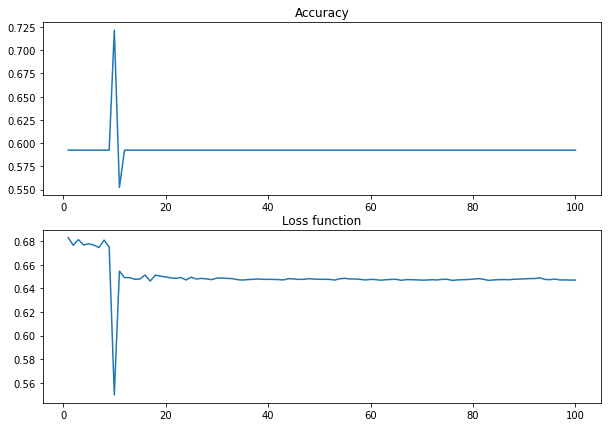

In [48]:
plot_history(history_model_4)

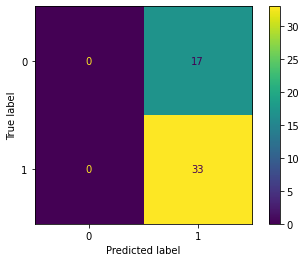

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(val_labels, model_4_preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [50]:
type(model_4_preds)

tensorflow.python.framework.ops.EagerTensor

### Trying to upgrade model 3 with Tensroflow Hub

In [51]:
model_5 = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dense(16,activation="relu"),
    tf.keras.layers.Dense(4,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")
],name="model_5_USE")

## Compile 
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                metrics=["accuracy"])
## Fit
history_model_5 = model_5.fit(train_sentences,
                              train_labels,
                              epochs=50,
                              validation_data=(val_sentences, val_labels),
                              verbose=0)

In [52]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

2/2 [==============================] - 1s 18ms/step


{'accuracy': 90.0, 'precision': 91.0, 'recall': 90.0, 'f1': 90.16731016731018}

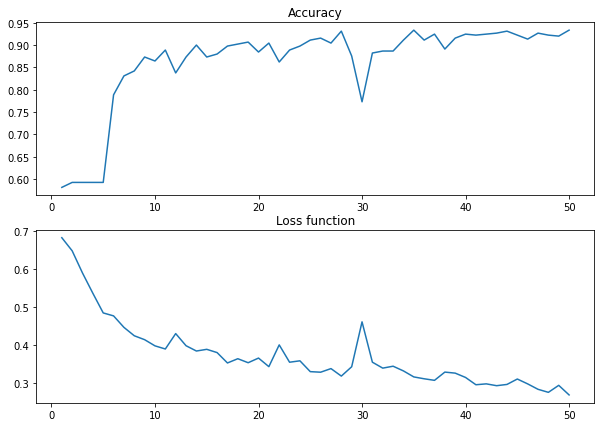

In [53]:
plot_history(history_model_5)

### Model 6: Conv1D with embedding

In [54]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = embedding(text_vectors)
x = tf.keras.layers.Conv1D(32, 
                           kernel_size=5, 
                           padding="same", 
                           activation="relu")(token_embeddings)
x = tf.keras.layers.MaxPooling1D()(x)
x = tf.keras.layers.Conv1D(16, 
                           kernel_size=5, 
                           padding="same", 
                           activation="relu")(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.MaxPooling1D()(x)
x = tf.keras.layers.Conv1D(8, 
                           kernel_size=5, 
                           padding="same", 
                           activation="relu")(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)                        
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_6 = tf.keras.Model(inputs, outputs)

## Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [55]:
## Fit
history_model_6 = model_6.fit(train_sentences,
                              train_labels,
                              epochs=100,
                              validation_data=(val_sentences, val_labels),
                              verbose=0)

In [56]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)
## Results
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

2/2 [==============================] - 0s 8ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 34.0,
 'precision': 11.56,
 'recall': 34.0,
 'f1': 17.253731343283583}

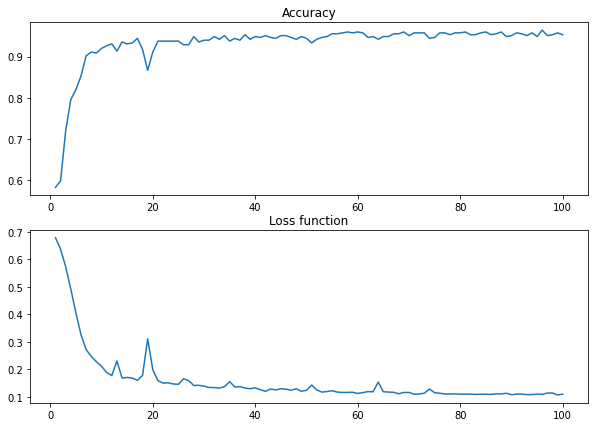

In [57]:
plot_history(history_model_6)